Каждый агент начинает со случайного мнения и среднего уровня неопределенности, за исключением нескольких "экстремистов", тех, кто имеет самые положительные или отрицательные мнения и очень низкий уровень неопределенности. Постройте агентную модель и убедитесь, что в этих условиях экстремизм распространяется, и в конечном итоге симуляция достигает устойчивого состояния, когда все агенты присоединяются к экстремистам на том или другом конце континуума мнений. Без определенных экстремистов агенты приходят к среднему мнению. Таким образом, модель показывает, что несколько экстремистов с ярко выраженными мнениями могут оказать существенное влияние на мнение большинства.

Deffuant G., Amblard F., Weisbuch G., Faure T. How Can Extremism Prevail? A Study Based on the Relative Agreement Interaction Model // Journal of Artificial Societies and Social Simulation. – 2002. – Vol. 5. – N 4.
http://jasss.soc.surrey.ac.uk/5/4/1.htmlLinks to an external site.

1) Реализовать модель парного взаимодействия. Реализовать модель все-со-всеми. (2 балла)
2) Оценить сходимость модели. (4 балла)
3) Реализовать ML модель предсказания числа кластеров (или иного показателя, введенного в п.2) (4 балла)

In [252]:
from mesa import Agent, Model
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Модель

Реализация самой модели сохранена в `main.py`

Характер взаимодействия (парное или все-со-всеми) регулируется параметром модели `pairwise`

**Важно**: при `pairwise=True` на каждом шаге участвуют все агенты (каждому находим пару и считаем). Обсуждали на семинаре, что асимптотически такой подход должен давать тот же результат, что и 1 пара в шаге, но при этом удобнее будет сравнивать модели в плане кол-ва шагов, если в обеих будут на каждом шаге все участвовать 

In [12]:
%autoreload 1
%aimport main

Посмотрим, работает ли модель вообще

Попарная

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1641.79it/s]


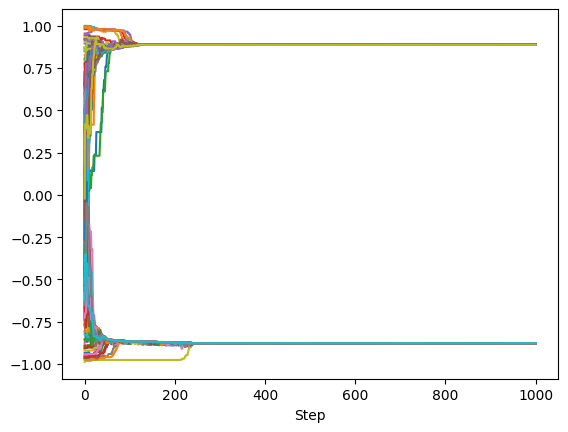

In [223]:
model1 = main.PolicitalModel(N=200, 
                             u=1.2,
                             u_e=0.1,
                             p_e=0.25,
                             mu=0.5,
                             delta=0,
                             pairwise=True,)

for _ in tqdm(range(1000)):
    model1.step()
    
model1.plot_dynamics()

In [170]:
ex_agents = pd.DataFrame([(i.x, i.u, i.unique_id, i.extremist) for i in model1.agents], columns=['X', 'U', 'Id', 'Extr'])

ex_agents.groupby(ex_agents.X.round(3)).Id.count()

X
-0.843    103
 0.793     89
 0.963      8
Name: Id, dtype: int64

100%|█████████████████████████████████████████| 400/400 [00:12<00:00, 32.65it/s]


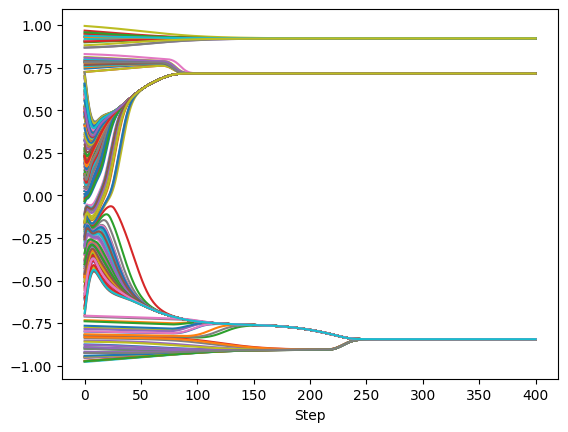

In [172]:
model2 = main.PolicitalModel(N=300, 
                             u=1.2,
                             u_e=0.1,
                             p_e=0.25,
                             mu=0.5,
                             delta=0,
                             pairwise=False,)

for _ in tqdm(range(400)):
    model2.step()
    
model2.plot_dynamics()

Окей, вроде оба варианта рабочие

Как мы видим сразу, вторая ожидаемо сходится "плавнее", тк мнение агента корректируется на среднее по больнице 

In [173]:
ex_agents2 = pd.DataFrame([(i.x, i.u, i.unique_id, i.extremist, i.initial_x) for i in model2.agents], columns=['X', 'U', 'Id', 'Extr', 'initial_x'])

ex_agents2.groupby(ex_agents2.X.round(3)).Id.count()

X
-0.845    113
 0.716    167
 0.922     20
Name: Id, dtype: int64

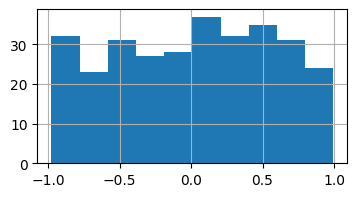

In [174]:
ex_agents2.initial_x.hist(figsize=(4, 2));

In [175]:
ex_agents2.initial_x.quantile(0.5)

0.051047952287499476

Перекос доли кажется объясним первоначальным распределением x

# 2 Сходимость

Здесь как будто нужно посмотреть на две вещи: 

- понять что вообще модель сходится к фикс. состоянию за адекватное кол-во шагов 
- посмотреть к чему она сходится (образовались ли кластеры, какие, проверить гипотезу, что при наличии некоторого кол-ва экстремистов мнения уходят в крайности, а при отсутствии сходятся к среднему)

Про сходимость в принципе: 

Вводим такой критерий: сумма модуля всех изменений мнений агентов должна быть меньше некоторого малого порога на протяжении некоторого кол-ва шагов

Если сумма изменений стабильно околонулевая, то считать дальнейшие шаги бессмысленно (консенсуса правда может и не быть, но это другой разговор)


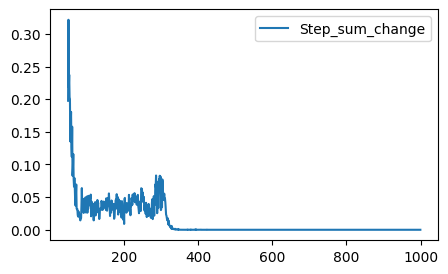

In [180]:
model1.model_datacollector.get_model_vars_dataframe()[50:].plot(figsize=(5, 3));

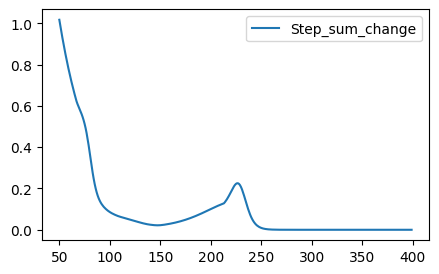

In [181]:
model2.model_datacollector.get_model_vars_dataframe()[50:].plot(figsize=(5, 3));

Критерий останова уже заложен в метод модели run() и зависит от параметров: 

* max_iter - максимально допустимое кол-во итераций. если для них критерий не выполнен можем считать, что модель не сошлась 
* change_threshold - порог для суммы изменений
* conv_check_periods_num - кол-во последних шагов модели, на которых проверяем порог

В целях экономии времени посмотрим на сходимость при N=200

Что влияет на саму возможность сходимости модели в смысле образования консенсуса мнений (кластера(-ов))?
Как будто в первую очередь степень неопределенности агентов.
Грубо говоря при u=0, мнения в принципе не будут меняться 

$\mu$ тоже влияет, но уже скорее на скорость сходимости, поэтому здесь это рассматривать не будем

In [207]:
model_without_extr = main.PolicitalModel(N=200, p_e=0, pairwise=True, u=0.001)

In [208]:
model_without_extr.run()

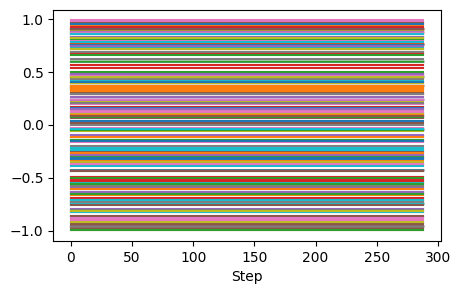

In [209]:
model_without_extr_data = model_without_extr.datacollector.get_agent_vars_dataframe().T.stack().T
model_without_extr_data.plot(legend=False, figsize=(5, 3))
plt.show();

Будем считать, что кластером мнений ситуацию, когда с разницей до 0.005 мнения принимают схожие значения 

(и можем проверять далее при этом, что кол-во агентов с этим мнением хоть сколько-ниубудь прилично велико) 

Округление конечно не идеально здесь работает, но, как мы видели на предыдущих примерах, в случае сходимости мнений к набору нескольких значений это довольно нелпохо отражает ситацию

Для чистоты эксперимента поставим max_iter большой, чтобы результат фиксировался только нашим критерием останова

А чтобы уменьшить эффект случайности будем смотреть модель "все-со-всеми"

In [195]:
num_clusters = []
converged = []
u_s = np.linspace(0, 1.2, num=20).round(2)

for u in tqdm(u_s):

    model_without_extr = main.PolicitalModel(N=200, p_e=0, pairwise=False, u=u, max_iter=10**3)
    model_without_extr.run()
    smth_like_clusters = model_without_extr.get_current_agents().X.round(2).value_counts(normalize=True)
    num_clusters.append(
        model_without_extr.get_current_agents().X.round(2).value_counts(normalize=True).shape[0]
    )
    converged.append(max(model_without_extr.check_change_list) < model_without_extr.change_threshold)

100%|███████████████████████████████████████████| 20/20 [01:15<00:00,  3.76s/it]


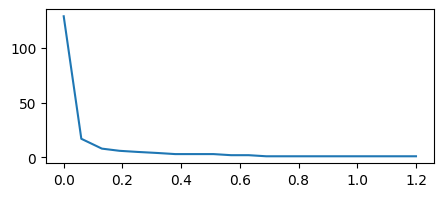

In [196]:
plt.figure(figsize=(5, 2))
plt.plot(u_s, num_clusters, label='num_clust');

In [197]:
min(u_s[np.array(num_clusters) < 2])

0.69

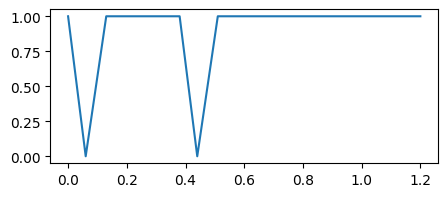

In [198]:
plt.figure(figsize=(5, 2))
plt.plot(u_s, [int(i) for i in converged]);

Методом, чуть превышающим по качеству МПВ (метод пристального взгляда), определили, что полный гкхм консенсус в обществе при отсутствии экстремистов достигается, грубо говоря, при u >= 0.7

Так же при u >= 0.7 и выше модель должна успевать сходиться 

**добавляем экстремистов**

Аналогично можем сделать для сетки u vs p_e, но там интересней буджет уже посмотреть на результаты в другом разрезе. 

К примеру, хочется посчитать при каких комбинациях p_e и u, мнения в обществе полностью поляризуются, а при каких нет
(логично предположить, что чем выше доля экстремистов с какой-либо из сторон и чем ниже уверенность агентов, тем больше шансов у мнений сойтись в эту сторону)

Смотреть результат будем не по кол-ву кластеров, а по метрике y из статьи, тк 1 кластер центре и один кластер на полюсе

$y = p_{e+}^2 + p_{e-}^2 $

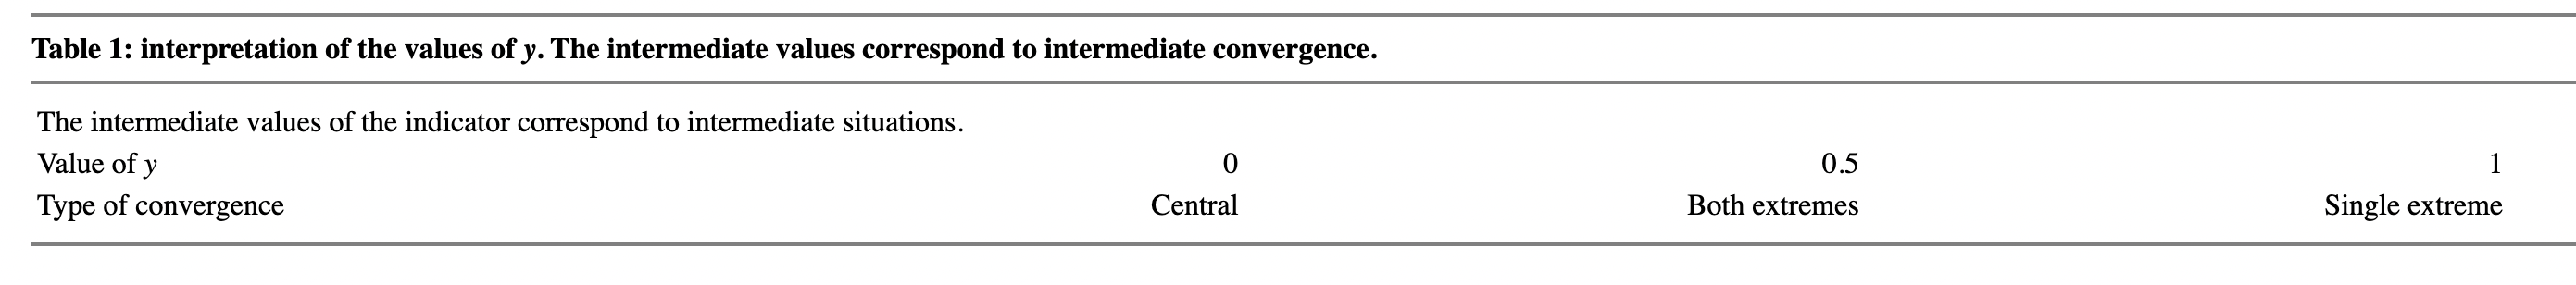

(честно очень хотел бы другие метрики попробовать, но сил примерно 1e-05 осталось)

In [215]:
NUM_PARAMS = 10

u_s_2 = np.linspace(0.69, 1.5, num=NUM_PARAMS).round(2)
p_e_list = np.linspace(0, 0.6, num=NUM_PARAMS).round(3)

In [230]:
def get_Y_on_grid(u_array=u_s_2, p_e_array=p_e_list):

    res_matrix = np.zeros((len(u_array), len(p_e_array)))

    converged_2 = []

    for i, u in tqdm(enumerate(u_array)):
        for j, p_e in tqdm(enumerate(p_e_array)):
            
            model = main.PolicitalModel(N=200, p_e=p_e, pairwise=False, u=u, max_iter=10**3)
            model.run()
            
            converged_2.append(max(model.check_change_list) < model.change_threshold)
            
            res_matrix[i, j] = model.get_y()

    return res_matrix, converged_2

In [231]:
res_matrix, converged_2 = get_Y_on_grid(u_array=u_s_2, p_e_array=p_e_list)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.53s/it]
2it [00:06,  3.65s/it]
3it [00:09,  3.13s/it]
4it [00:20,  6.41s/it]
5it [00:29,  7.32s/it]
6it [00:43,  9.59s/it]
7it [00:55, 10.34s/it]
8it [01:07, 10.81s/it]
9it [01:15,  9.89s/it]
10it [01:23,  8.33s/it]
1it [01:23, 83.26s/it]
0it [00:00, ?it/s]
1it [00:02,  2.05s/it]
2it [00:05,  2.88s/it]
3it [00:08,  2.81s/it]
4it [00:22,  7.36s/it]
5it [00:28,  6.86s/it]
6it [00:36,  7.19s/it]
7it [00:43,  7.09s/it]
8it [00:51,  7.39s/it]
9it [00:59,  7.79s/it]
10it [01:07,  6.74s/it]
2it [02:30, 73.91s/it]
0it [00:00, ?it/s]
1it [00:02,  2.01s/it]
2it [00:05,  3.07s/it]
3it [00:08,  2.89s/it]
4it [00:12,  3.23s/it]
5it [00:16,  3.52s/it]
6it [00:20,  3.88s/it]
7it [00:25,  3.98s/it]
8it [00:30,  4.48s/it]
9it [00:35,  4.53s/it]
10it [00:45,  4.52s/it]
3it [03:15, 60.82s/it]
0it [00:00, ?it/s]
1it [00:01,  1.95s/it]
2it [00:06,  3.21s/it]
3it [00:09,  3.14s/it]
4it [00:11,  2.88s/it]
5it [00:16,  3.53s/it]
6it [00:24,  5.02s/it]
7it [

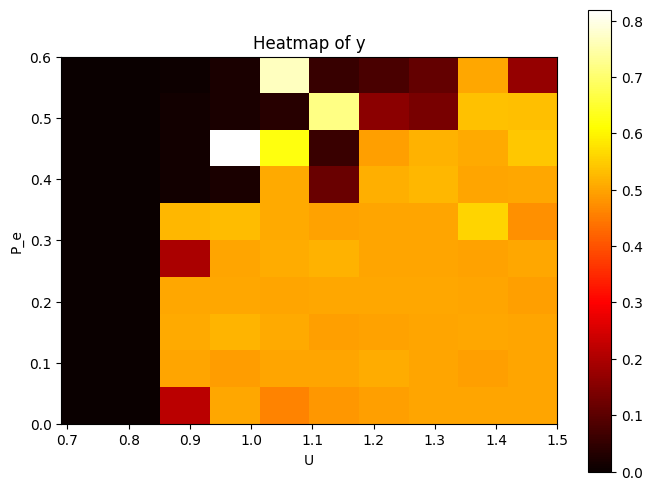

In [233]:
# Create heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    res_matrix, cmap='hot', interpolation='nearest',
           origin='lower', extent=[min(u_s_2), max(u_s_2), min(p_e_list), max(p_e_list)]
          )
plt.colorbar()
plt.xlabel('U')
plt.ylabel('P_e')
plt.title('Heatmap of y')
plt.show()

In [235]:
np.mean(converged_2)

0.82

Как видим при расте степени неувернности мы чаще приходим в ситуацию с 2 полюсами мнений в обществе (почти вся диаграмма у нас оранжевенькая, т.е. y находится где-то в районе 0.5)

При этом, при высоких значениях p_e образуется несколько кластеров у экстремистов, что довольно интересно

In [244]:
model5 = main.PolicitalModel(N=200, p_e=0.4, pairwise=False, u=1.5, max_iter=10**3)
model5.run()

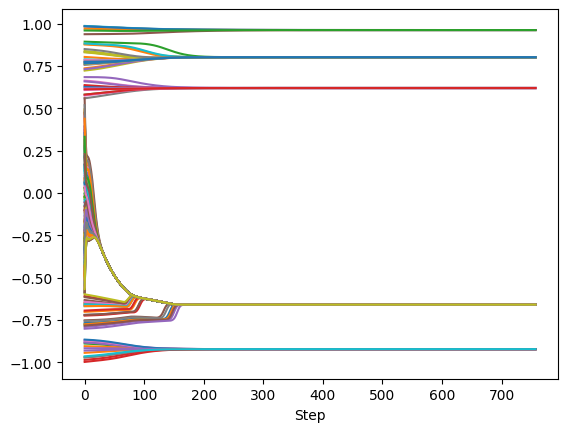

In [250]:
model5.plot_dynamics();

Логично, кмк, в дальнейшем ограничивать p_e до 0.3 например, тк все же экстремисты на то и экстремисты, чтобы их было немного

Если половина населения экстремисты, то это как будто уже "нормальное" состояние для общества

# 3 ML 

## \+ еще немножко сходимости

Мы уже посмотрели, что модели попарного взаимодействия и "все-со-всеми" ведут себя схожим образом в плане результатов и 
даже сходимости. Здесь можно провести аналогию такую: "все-со-всеми" - это как градиентный спуск, а попарное взаимодействие - как SGD

Я тут подвожу к тому, что как будто мы имеем право использовать попарный подход и надеяться получить +/- те же результаты. С разной дисперсией вероятно (я предполагал сначала, что она выше у парной модели) и отличающимся необходимым кол-вом шагов (предполагал, что "все-со-всеми" нужно меньше)


*небольшое исследование*

В плане сравнения двух подходов к моделированию шагов, попробуем посчитать хотя бы для какого-то одного набора параметров N реализаций этих моделей и посмотреть на распределение нашей метрики **y** (а в идеале конечно тоже по сетке нужно)

In [336]:
y_pairwise = []
y_every = []
N_pairwise = []
N_every = []

for _ in tqdm(range(100)):

    model_pair = main.PolicitalModel(N=200, pairwise=True,)
    model_pair.run()
    model_every = main.PolicitalModel(N=200, pairwise=False,)
    model_every.run()
    
    y_pairwise.append(model_pair.get_y())
    y_every.append(model_every.get_y())

    N_pairwise.append(model_pair.run_iters)
    N_every.append(model_every.run_iters)


100%|█████████████████████████████████████████| 100/100 [13:27<00:00,  8.08s/it]


In [382]:
np.median(y_pairwise), np.mean(y_pairwise), np.std(y_pairwise)

(0.5005250000000001, 0.5017725, 0.006951857215881234)

In [381]:
np.median(y_every), np.mean(y_every), np.std(y_every)

(0.5024500000000001, 0.4785185, 0.12203279055340004)

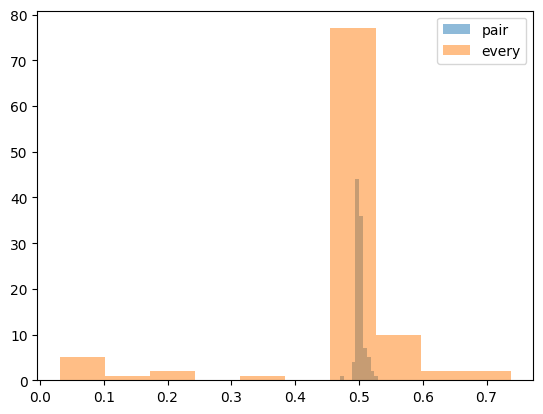

In [368]:
plt.hist(y_pairwise, alpha=0.5, label='pair', bins=10);
plt.hist(y_every, alpha=0.5, label='every', bins=10);
plt.legend();

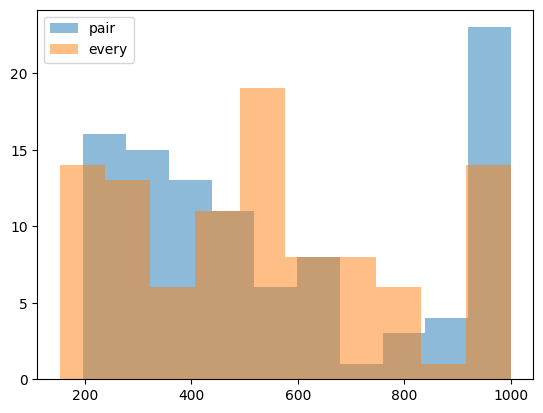

In [372]:
plt.hist(N_pairwise, alpha=0.5, label='pair', bins=10);
plt.hist(N_every, alpha=0.5, label='every', bins=10);
plt.legend();

Не могу прям на 100% понять, почему по модели все-со-всеми дисперсия получилась больше

Одна из идей, что в такой модели первоначальное распределение/выбросы бОльшую роль играют, тк какой-нибудь перекос даже совсем небольшой за счет участия "участников перекоса" во всех взаимодействиях - будет сильнее отражаться на финальном распределении 

И при этом распределение кол-ва N, которое необходимо для достижения нашего критерия останова, тоже отличается несильно

##  Сама ML-ка 

чтобы какие-то баллы все же получить:

In [295]:
# сформируем сетку параметров

Num_params = 8

p_e_list = np.linspace(0, 0.3, num=Num_params).round(2)
u_list = np.linspace(0.7, 1.5, num=Num_params).round(2)
u_e_list = np.linspace(0.05, 0.3, num=Num_params).round(2)
delta_list = np.linspace(0, 0.9, num=5).round(2)
mu_list = np.linspace(0.1, 1, num=5).round(2)

parameters = [p_e_list, u_list, u_e_list, delta_list, mu_list]
param_names=['p_e', 'u', 'u_e', 'delta', 'mu']

combinations = [{param_names[i]: j[i] for i in range(len(j))} for j in itertools.product(*parameters)]

len(combinations)

12800

Для обучения ML будем считать выборку на попарной, тк скорость сходимости по кол-ву шагов по отношению ко времени сходимости ей дает ощутимое здесь преимущество

In [310]:
def calculate_data(param_combinations, param_names=['p_e', 'u', 'u_e', 'delta', 'mu']):

    d = {i: [0]*len(param_combinations) for i in param_names}
    d['converged'] = [0]*len(param_combinations)
    d['y'] = [0]*len(param_combinations)

    for i in tqdm(range(len(param_combinations))):
        
        model = main.PolicitalModel(N=200, change_threshold=1e-05, **param_combinations[i])
        model.run()
        
        for name in param_names:
            d[name][i] = param_combinations[i][name]
            
        d['y'][i] = model.get_y()
        d['converged'][i] = max(model.check_change_list) < model.change_threshold
        
    return d

In [297]:
data_dict = calculate_data(combinations)

100%|███████████████████████████████████| 12800/12800 [1:18:28<00:00,  2.72it/s]


In [305]:
pd.DataFrame(data_dict).to_csv('sample_data.csv', index=False)

In [306]:
df = pd.read_csv('sample_data.csv', )

In [320]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

def calc_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print("Train RMSE = %.4f" % metrics.mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test RMSE = %.4f" % metrics.mean_squared_error(y_test, y_test_pred, squared=False))
    print("Test MAE = %.4f" % metrics.mean_absolute_error(y_test, y_test_pred))
    print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_test), y_test_pred))

In [318]:
y = df['y']
X = df[param_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [330]:
X_train.head(1)

,p_e,u,u_e,delta,mu
7069,0.17,1.04,0.12,0.68,0.5


Ну чего, классика от студента ФТиАДа? Из пушки по воробьям, а то есть сразу градиентный бустинг

In [322]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(nthread=4, seed=21)

param_grid = {
     'n_estimators': [50, 100, 200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.025, 0.05],
}

clf = GridSearchCV(xgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(X_train, y_train)
print('Best params:', clf.best_params_)
print('Best score:', clf.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400}
Best score: -0.16327829575763295


In [323]:
best = xgb.XGBRegressor(**clf.best_params_)

best.fit(X_train, y_train)

y_train_pred, y_test_pred = best.predict(X_train), best.predict(X_test)
calc_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train RMSE = 0.1576
Test RMSE = 0.1577
Test MAE = 0.1064
Test R^2 = 0.7096


Нуууу, неплохо, я, признаться, думал, что будет хуже

По классике позитивный мем в конце дз


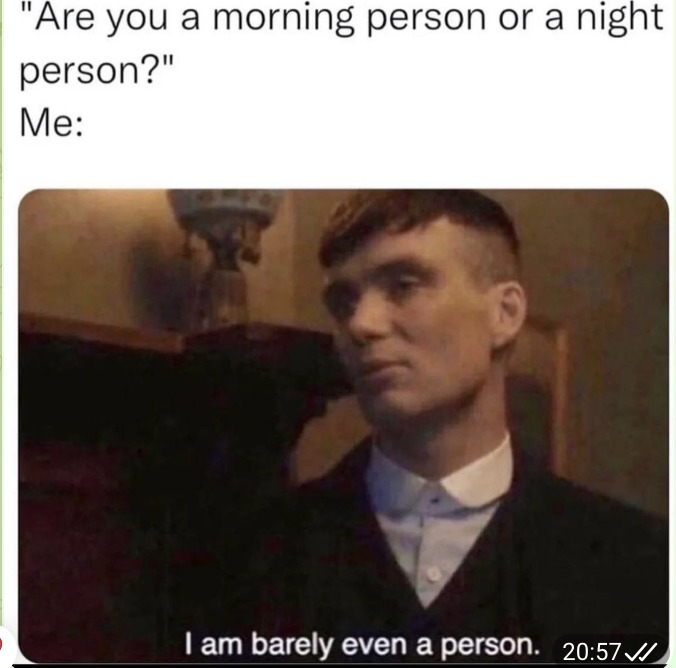